# Homework 4

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2025

***

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from datetime import date
from dateutil.relativedelta import relativedelta

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Data

The file `data/ratetree_data_2025-01-31.xlsx` has a binomial tree of interest rates fit to...
* discount curves from `cap_curves_2025-01-31.xlsx`
* implied vols from `cap_curves_2025-01-31.xlsx`

Note the following...
* Suppose the present date is `2025-01-31`.
* The rates are continuously compounded.
* The rates are for the following quarter. So the rate at $t=0$ is the continuously compounded rate for the interval $t=0$ to $t=.25$.

Take this binomial tree as given; there is no need to fit it yourself.

In [2]:
df_rate_curves = pd.read_excel("../data/cap_curves_2025-01-31.xlsx", sheet_name="rate curves 2025-01-31").set_index("tenor")
df_rate_curves.head()

,swap rates,spot rates,discounts,forwards,flat vols,fwd vols
tenor,,,,,,
0.25,0.042340,0.042340,0.989526,NaN,NaN,NaN
0.50,0.041854,0.041852,0.979398,0.041364,0.101500,0.101500
0.75,0.041404,0.041397,0.969584,0.040489,0.116946,0.128478
1.00,0.041029,0.041018,0.960012,0.039882,0.132391,0.154562
1.25,0.040458,0.040438,0.950950,0.038117,0.159421,0.219138


In [3]:
DATE = '2025-01-31'
FILEIN = f'../data/ratetree_data_{DATE}.xlsx'
sheet_tree = 'rate tree'

ratetree = pd.read_excel(FILEIN, sheet_name=sheet_tree).set_index('state')
ratetree.columns.name = 'time'

ratetree.style.format('{:.1%}',na_rep='').format_index('{:.2f}',axis=1)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75
state,,,,,,,,,,,,,,,,,,,,
0,4.2%,4.3%,4.4%,4.8%,5.1%,6.4%,7.6%,9.1%,10.1%,11.8%,13.5%,15.3%,16.9%,19.2%,22.7%,25.9%,28.2%,30.6%,34.7%,40.3%
1,,3.9%,4.0%,4.2%,4.4%,5.2%,6.0%,7.0%,7.8%,9.0%,10.4%,11.8%,13.0%,14.8%,17.4%,19.9%,21.7%,23.7%,27.0%,31.2%
2,,,3.6%,3.7%,3.8%,4.2%,4.7%,5.4%,6.0%,7.0%,8.0%,9.1%,10.1%,11.4%,13.4%,15.3%,16.7%,18.4%,20.9%,24.2%
3,,,,3.3%,3.2%,3.3%,3.7%,4.2%,4.6%,5.3%,6.2%,7.0%,7.8%,8.8%,10.3%,11.8%,12.9%,14.2%,16.3%,18.8%
4,,,,,2.8%,2.7%,2.9%,3.3%,3.6%,4.1%,4.7%,5.4%,6.0%,6.8%,7.9%,9.1%,10.0%,11.0%,12.6%,14.6%
5,,,,,,2.2%,2.3%,2.5%,2.7%,3.2%,3.6%,4.2%,4.6%,5.2%,6.1%,7.0%,7.7%,8.6%,9.8%,11.3%
6,,,,,,,1.8%,2.0%,2.1%,2.4%,2.8%,3.2%,3.6%,4.0%,4.7%,5.4%,5.9%,6.6%,7.6%,8.8%
7,,,,,,,,1.5%,1.6%,1.9%,2.2%,2.5%,2.7%,3.1%,3.6%,4.1%,4.6%,5.1%,5.9%,6.8%
8,,,,,,,,,1.3%,1.4%,1.7%,1.9%,2.1%,2.4%,2.8%,3.2%,3.5%,4.0%,4.6%,5.3%


***

# 1. Binomial Tree Pricing - Bond

### The Bond

Consider a vanilla (non-callable) bond with the following parameters...
* `T=5`
* coupon rate is `4.41%`
* coupons are semiannual

Note that this is essentially the hypothetical bond priced in HW 1.

### 1.1

Create and display a tree of cashflows from the bond, corresponding to each node of the tree (state and time) seen in the interest rate tree.

Note that the cashflows do not depend on the interest rates. Thus, report the cashflows at the time (in the column) they are actually paid out. The final payoff (face plus coupon) occurs at $T$, which is beyond the interest rate tree. You are welcome to add a column for $T$ or to consider this payoff separately and leave it out of the tree.

In [4]:
def bond_cashflow_tree(states,cols,face,coupon_annual,maturity):
    cf=pd.DataFrame(0,index=states,columns=cols)
    coupon=face*(coupon_annual/2)
    times_needed=np.array(cf.columns.tolist())
    if maturity not in times_needed:
        times_needed=np.append(times_needed,maturity)
    times_needed=np.sort(times_needed)
    cf=cf.reindex(columns=times_needed,fill_value=0)
    pay_times=np.arange(0.5,maturity+0.001,0.5)
    for pt in pay_times:
        if pt<maturity:
            cf[pt]=coupon
        else:
            cf[pt]=face+coupon
    return cf

In [5]:
face_value=100
coupon_rate=0.0441
maturity=5
cf_tree=bond_cashflow_tree(
    states=ratetree.index,
    cols=ratetree.columns,
    face=face_value,
    coupon_annual=coupon_rate,
    maturity=maturity
)
cf_tree.style.format(na_rep='').format_index('{:.2f}',axis=1)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00
state,,,,,,,,,,,,,,,,,,,,,
0,0,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,102.205000
1,0,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,102.205000
2,0,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,102.205000
3,0,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,102.205000
4,0,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,102.205000
5,0,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,102.205000
6,0,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,102.205000
7,0,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,102.205000
8,0,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,2.205000,0,102.205000


### 1.2.

Create and display a tree of values of the bond. Do this for the quotes as
* clean quotes
* dirty quotes

Given the semiannual coupons and quarterly tree steps, the clean and dirty will coincide at $t=0, .5, 1,...$.

Do the valuation by...
* setting the value at $T$ as the face plus final coupon.
* discounting this back through time, using the (continuously-compounded) interest rate.
* recall that the tree is constructed such that the probability of moving "up" or "down" is 50%.

In [6]:
def accrued_interest(t,face,coupon_annual):
    lc=0.5*np.floor(t/0.5)
    f=(t-lc)/0.5
    return face*(coupon_annual/2)*f

def bond_value_tree(ratetree,cf_tree,face,coupon_annual):
    times=np.sort(cf_tree.columns)
    val_dirty=pd.DataFrame(0,index=cf_tree.index,columns=times)
    val_dirty.loc[:,times[-1]]=cf_tree.loc[:,times[-1]]
    for i in range(len(times)-2,-1,-1):
        dt=times[i+1]-times[i]
        for s in val_dirty.index:
            sd=s+1 if s+1 in val_dirty.index else s
            ev=0.5*val_dirty.loc[s,times[i+1]]+0.5*val_dirty.loc[sd,times[i+1]]
            val_dirty.loc[s,times[i]]=cf_tree.loc[s,times[i]]+np.exp(-ratetree.loc[s,times[i]]*dt)*ev
    val_clean=val_dirty.copy()
    for t in times:
        val_clean[t]=val_clean[t]-accrued_interest(t,face,coupon_annual)
    return val_dirty,val_clean

In [7]:
val_dirty,val_clean=bond_value_tree(ratetree,cf_tree,face_value,coupon_rate)
val_dirty.style.format(na_rep='').format_index('{:.2f}',axis=1)

,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00
state,,,,,,,,,,,,,,,,,,,,,
0,101.869401,101.020606,100.038066,96.674771,95.412415,91.804347,90.561114,87.209059,86.276634,83.234494,82.683237,80.182270,80.271327,78.422727,79.356835,78.871143,81.619125,83.017188,87.901687,92.411267,102.205000
1,,104.874751,104.198996,101.179152,100.262969,97.006495,96.027611,92.901158,92.134736,89.229230,88.757972,86.297496,86.364216,84.453333,85.218808,84.423561,86.664663,87.393012,91.350206,94.526329,102.205000
2,,,107.609029,104.868428,104.234514,101.267177,100.510592,97.577717,96.958541,94.177536,93.782819,91.361871,91.411396,89.445063,90.062346,88.994402,90.795758,90.948229,94.121954,96.199500,102.205000
3,,,,107.861708,107.450967,104.713944,104.138429,101.366170,100.872595,98.200304,97.874791,95.490134,95.526543,93.512637,94.004142,92.704542,94.136113,93.806834,96.332291,97.517148,102.205000
4,,,,,110.034062,107.475596,107.043995,104.401717,104.012321,101.432140,101.166870,98.814212,98.840717,96.787106,97.174574,95.683329,96.811009,96.086825,98.084197,98.551194,102.205000
5,,,,,,109.671862,109.352437,106.813373,106.508629,104.004803,103.790593,101.465365,101.484465,99.398401,99.701469,98.054765,98.936965,97.893949,99.466184,99.360480,102.205000
6,,,,,,,111.175060,108.716765,108.479758,106.038212,105.866449,103.564265,103.577880,101.465706,101.701306,99.930349,100.616810,99.319321,100.552357,99.992531,102.205000
7,,,,,,,,110.211354,110.027926,107.636569,107.499592,105.216479,105.226070,103.093144,103.275412,101.406252,101.938170,100.439347,101.403601,100.485356,102.205000
8,,,,,,,,,111.238893,108.887614,108.778841,106.511335,106.518000,104.368733,104.509208,102.563094,102.973917,101.316862,102.069250,100.869139,102.205000


In [8]:
val_clean.style.format(na_rep='').format_index('{:.2f}',axis=1)

,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00
state,,,,,,,,,,,,,,,,,,,,,
0,101.869401,99.918106,100.038066,95.572271,95.412415,90.701847,90.561114,86.106559,86.276634,82.131994,82.683237,79.079770,80.271327,77.320227,79.356835,77.768643,81.619125,81.914688,87.901687,91.308767,102.205000
1,,103.772251,104.198996,100.076652,100.262969,95.903995,96.027611,91.798658,92.134736,88.126730,88.757972,85.194996,86.364216,83.350833,85.218808,83.321061,86.664663,86.290512,91.350206,93.423829,102.205000
2,,,107.609029,103.765928,104.234514,100.164677,100.510592,96.475217,96.958541,93.075036,93.782819,90.259371,91.411396,88.342563,90.062346,87.891902,90.795758,89.845729,94.121954,95.097000,102.205000
3,,,,106.759208,107.450967,103.611444,104.138429,100.263670,100.872595,97.097804,97.874791,94.387634,95.526543,92.410137,94.004142,91.602042,94.136113,92.704334,96.332291,96.414648,102.205000
4,,,,,110.034062,106.373096,107.043995,103.299217,104.012321,100.329640,101.166870,97.711712,98.840717,95.684606,97.174574,94.580829,96.811009,94.984325,98.084197,97.448694,102.205000
5,,,,,,108.569362,109.352437,105.710873,106.508629,102.902303,103.790593,100.362865,101.484465,98.295901,99.701469,96.952265,98.936965,96.791449,99.466184,98.257980,102.205000
6,,,,,,,111.175060,107.614265,108.479758,104.935712,105.866449,102.461765,103.577880,100.363206,101.701306,98.827849,100.616810,98.216821,100.552357,98.890031,102.205000
7,,,,,,,,109.108854,110.027926,106.534069,107.499592,104.113979,105.226070,101.990644,103.275412,100.303752,101.938170,99.336847,101.403601,99.382856,102.205000
8,,,,,,,,,111.238893,107.785114,108.778841,105.408835,106.518000,103.266233,104.509208,101.460594,102.973917,100.214362,102.069250,99.766639,102.205000


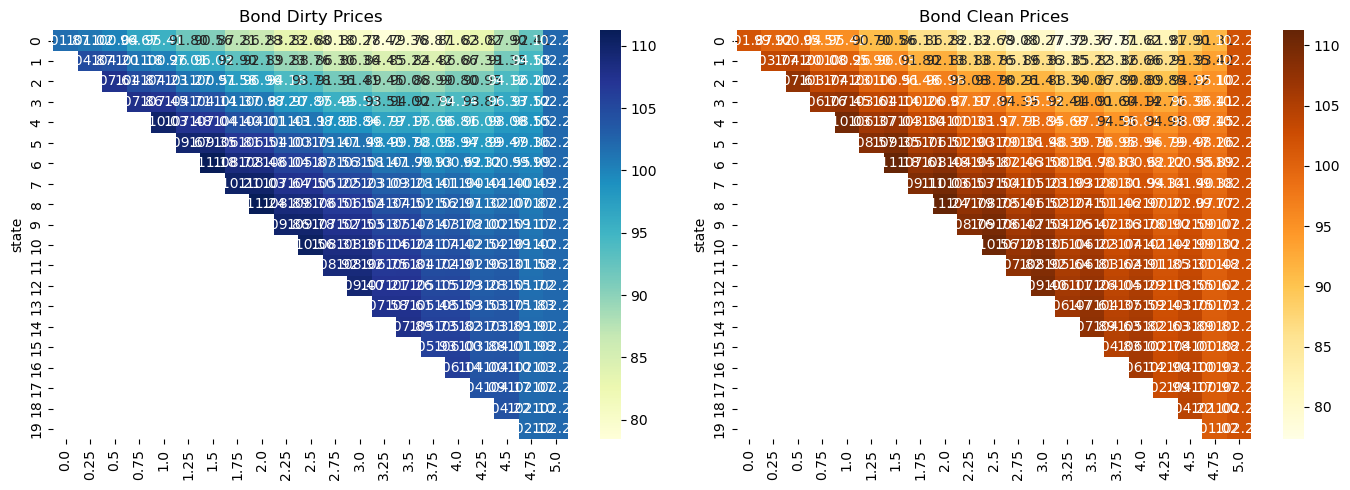

In [9]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.heatmap(val_dirty,annot=True,cmap="YlGnBu",fmt=".2f")
plt.title("Bond Dirty Prices")
plt.subplot(1,2,2)
sns.heatmap(val_clean,annot=True,cmap="YlOrBr",fmt=".2f")
plt.title("Bond Clean Prices")
plt.tight_layout()
plt.show()

### 1.3.

The binomial-estimated price of the bond is the initial node of the value tree.

Report this along with the price of the bond you would get from the usual simple formula for such a bond. 
* Consider pricing it with the $T$ interval swap rate (used similar to a ytm) from the file `cap_curves_2025-01-31.xlsx`.
* If you do this, recall that the swap rate given in that file is quarterly-compounded, so you would need to convert it to semiannual compounding before plugging it into the usual closed-form ytm-pricing formula.

### Note:

An easy check on your code is whether it will correctly price a zero-coupon bond at a price that matches the "discounts" in the `cap_curves` data file.

In [10]:
def any_to_any(x,freq_from,freq_to):
    def convert_scalar(r,f1,f2):
        if f1=='cont':
            e=np.exp(r)-1
        else:
            e=(1+r/f1)**f1-1
        if f2=='cont':
            return np.log(1+e)
        else:
            return f2*((1+e)**(1/f2)-1)
    if isinstance(x,(int,float)):
        return convert_scalar(x,freq_from,freq_to)
    return x.apply(lambda r: convert_scalar(r,freq_from,freq_to))

In [11]:
swap_rates_quarterly = df_rate_curves[["swap rates"]]
swap_rates_semi_annual = any_to_any(swap_rates_quarterly, 4, 2)
swap_rates_semi_annual.head()

,swap rates
tenor,
0.25,0.042564
0.50,0.042073
0.75,0.041618
1.00,0.041239
1.25,0.040663


In [12]:
def generate_coupon_dates(issue_date,maturity_date,freq):
    step=12//freq
    dates=[]
    n=0
    while True:
        d=issue_date+pd.DateOffset(months=n*step)
        if d>=maturity_date:
            break
        dates.append(d)
        n+=1
    dates.append(maturity_date)
    return dates

def year_fraction(d1,d2):
    return (d2-d1).days/365.0

def bond_price_ytm(cusip,coupon_rate,date_quoted,date_issued,maturity_date,coupon_frequency,ytm,face_value=100):
    if not isinstance(date_quoted,pd.Timestamp):
        date_quoted=pd.to_datetime(date_quoted)
    if not isinstance(date_issued,pd.Timestamp):
        date_issued=pd.to_datetime(date_issued)
    if not isinstance(maturity_date,pd.Timestamp):
        maturity_date=pd.to_datetime(maturity_date)
    coupon_dates=generate_coupon_dates(date_issued,maturity_date,coupon_frequency)
    cds=[c for c in coupon_dates if c>date_quoted]
    cpn=face_value*(coupon_rate/coupon_frequency)
    dfs=np.array([year_fraction(date_quoted,d) for d in cds])
    p=ytm/coupon_frequency
    discount_factors=(1+p)**(-coupon_frequency*dfs)
    cf=np.full(len(cds),cpn)
    if len(cds)>0:
        cf[-1]+=face_value
    dirty_price=np.sum(cf*discount_factors)
    prev_coupon_candidates=[d for d in coupon_dates if d<=date_quoted]
    prev_coupon_date=max(prev_coupon_candidates)if prev_coupon_candidates else date_issued
    next_coupon_candidates=[d for d in coupon_dates if d>date_quoted]
    next_coupon_date=min(next_coupon_candidates)if next_coupon_candidates else maturity_date
    denom=year_fraction(prev_coupon_date,next_coupon_date)
    num=year_fraction(prev_coupon_date,date_quoted)
    fraction_elapsed=num/denom if denom!=0 else 0
    accrued=cpn*fraction_elapsed
    clean_price=dirty_price-accrued
    return{'cusip':cusip,'clean_price':clean_price,'dirty_price':dirty_price,'accrued_interest':accrued}


In [13]:
bond_price_using_swap_rate = bond_price_ytm(
    cusip="", 
    coupon_rate=coupon_rate, 
    date_quoted=datetime.now(), 
    date_issued=datetime.now(), 
    maturity_date=datetime.now() + relativedelta(years=5), 
    coupon_frequency=2, 
    ytm=float(swap_rates_semi_annual.loc[5]), 
    face_value=100)

bond_price_using_swap_rate

{'cusip': '',
 'clean_price': 104.06323323630325,
 'dirty_price': 104.06323323630325,
 'accrued_interest': 0.0}

***

# 2. Pricing the Callable - European

### 2.1.

Calculate and display value tree of a European-style call option on the bond analyzed in part `1`.
* `$T_o = 3$`. That is, the time-to-expiration is 3 years.
* `$K=100$`. That is, the strike is 100. This is a clean strike, meaning exercise requires paying the strike plus any accrued interest.

Do so by 
* setting the value at the time of expiration, using the value of the bond for each node at that time.
* discounting this back through time, using the (continuously-compounded) interest rate.
* recall that the tree is constructed such that the probability of moving "up" or "down" is 50%.

Note that...
* the tree of call values will not be the same size as the tree of bond values. The former goes only to $T_o=3$.

In [14]:
def call_redemption_price(t, K, face, coupon_annual):
    if (t * 2).is_integer():
        return K + face*(coupon_annual/2)
    else:
        return K + accrued_interest(t, face, coupon_annual)

def european_call_value_tree(ratetree, val_dirty, val_clean, T_o, K, face, coupon_annual):
    times = np.sort(val_dirty.columns)
    times = times[times <= T_o]
    call_dirty = pd.DataFrame(0.0, index=val_dirty.index, columns=times)
    for s in call_dirty.index:
        rd = call_redemption_price(T_o, K, face, coupon_annual)
        call_dirty.loc[s, T_o] = max(0, val_dirty.loc[s, T_o] - rd)
    for i in range(len(times) - 2, -1, -1):
        t = times[i]
        dt = times[i+1] - t
        for s in call_dirty.index:
            s_down = s + 1 if (s + 1 in call_dirty.index) else s
            pd_dirty = 0.5 * call_dirty.loc[s_down, times[i+1]]
            pu_dirty = 0.5 * call_dirty.loc[s,     times[i+1]]
            r = ratetree.loc[s, t]
            call_dirty.loc[s, t] = np.exp(-r * dt) * (pu_dirty + pd_dirty)
    return call_dirty

In [15]:
call_dirty = european_call_value_tree(
    ratetree, val_dirty, val_clean, 3, 100, face_value, coupon_rate
)

call_dirty.iloc[:len(call_dirty.columns)].style.format(na_rep='').format_index('{:.2f}',axis=1)

,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
state,,,,,,,,,,,,,
0,1.649126,1.201129,0.803438,0.477417,0.238586,0.090143,0.019658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,,2.132035,1.624929,1.147426,0.727733,0.393162,0.163554,0.040073,0.000000,0.000000,0.000000,0.000000,0.000000
2,,,2.680990,2.135244,1.591378,1.078318,0.633004,0.291976,0.081565,0.000000,0.000000,0.000000,0.000000
3,,,,3.275625,2.718787,2.134418,1.546149,0.989053,0.510393,0.165602,0.000000,0.000000,0.000000
4,,,,,3.885962,3.347009,2.758451,2.132081,1.488716,0.867067,0.335657,0.000000,0.000000
5,,,,,,4.478587,3.980576,3.425263,2.810521,2.137012,1.416370,0.679304,0.000000
6,,,,,,,5.024938,4.581780,4.083670,3.522717,2.891505,2.179346,1.372880
7,,,,,,,,5.513656,5.125159,4.687862,4.196771,3.644329,3.021070
8,,,,,,,,,5.944382,5.604204,5.222737,4.794597,4.313000


### 2.2.

Show the value tree of the callable bond by subtracting the call value tree from the (subset $t\le T_o$ of the) bond value tree (calculated in part `1`.) Do this for both
* clean
* dirty

In [16]:
times = np.sort(val_dirty.columns)
times = times[times <= 3]

callable_bond_dirty = val_dirty[times] - call_dirty
callable_bond_dirty.iloc[:len(callable_bond_dirty.columns)].style.format(na_rep='').format_index('{:.2f}',axis=1)

,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
state,,,,,,,,,,,,,
0,100.220274,99.819477,99.234628,96.197354,95.173829,91.714203,90.541455,87.209059,86.276634,83.234494,82.683237,80.182270,80.271327
1,,102.742715,102.574067,100.031726,99.535236,96.613333,95.864057,92.861085,92.134736,89.229230,88.757972,86.297496,86.364216
2,,,104.928038,102.733184,102.643135,100.188860,99.877588,97.285741,96.876976,94.177536,93.782819,91.361871,91.411396
3,,,,104.586082,104.732180,102.579526,102.592280,100.377117,100.362202,98.034702,97.874791,95.490134,95.526543
4,,,,,106.148101,104.128586,104.285545,102.269636,102.523605,100.565073,100.831213,98.814212,98.840717
5,,,,,,105.193276,105.371861,103.388110,103.698108,101.867791,102.374224,100.786061,101.484465
6,,,,,,,106.150122,104.134985,104.396088,102.515495,102.974944,101.384918,102.205000
7,,,,,,,,104.697698,104.902767,102.948707,103.302821,101.572150,102.205000
8,,,,,,,,,105.294511,103.283410,103.556103,101.716738,102.205000


In [17]:
callable_bond_clean = val_clean[times] - call_dirty
callable_bond_clean.iloc[:len(callable_bond_dirty.columns)].style.format(na_rep='').format_index('{:.2f}',axis=1)

,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
state,,,,,,,,,,,,,
0,100.220274,98.716977,99.234628,95.094854,95.173829,90.611703,90.541455,86.106559,86.276634,82.131994,82.683237,79.079770,80.271327
1,,101.640215,102.574067,98.929226,99.535236,95.510833,95.864057,91.758585,92.134736,88.126730,88.757972,85.194996,86.364216
2,,,104.928038,101.630684,102.643135,99.086360,99.877588,96.183241,96.876976,93.075036,93.782819,90.259371,91.411396
3,,,,103.483582,104.732180,101.477026,102.592280,99.274617,100.362202,96.932202,97.874791,94.387634,95.526543
4,,,,,106.148101,103.026086,104.285545,101.167136,102.523605,99.462573,100.831213,97.711712,98.840717
5,,,,,,104.090776,105.371861,102.285610,103.698108,100.765291,102.374224,99.683561,101.484465
6,,,,,,,106.150122,103.032485,104.396088,101.412995,102.974944,100.282418,102.205000
7,,,,,,,,103.595198,104.902767,101.846207,103.302821,100.469650,102.205000
8,,,,,,,,,105.294511,102.180910,103.556103,100.614238,102.205000


### 2.3.

Report the initial node value of the call option and of the callable bond.

In a table, compare these to what you got in HW 1 as the value of the embedded call and the value of the callable bond.
* In `HW 1`, we were valuing from a date nearly two weeks later, `2025-02-13`. This difference in the timing means we wouldn't expect the values to match exactly, even if the methods were entirely consistent.

In [18]:
print("Call Option Initial Node (Dirty):", call_dirty.iloc[0, 0])
print("Callable Bond Initial Node (Dirty):", callable_bond_dirty.iloc[0, 0])
print("Callable Bond Initial Node (Clean):", callable_bond_clean.iloc[0, 0])

Call Option Initial Node (Dirty): 1.6491264607184222
Callable Bond Initial Node (Dirty): 100.22027411898708
Callable Bond Initial Node (Clean): 100.22027411898708


***

# 3. Pricing the Callable - American

### 3.1.

Re-do part `2.`, but this time, make the option a **American** style. That is, allow it to be exercised at any node.
* Report the tree of callable-bond values.
* How does this compare to the European-style?

#### Note
To do this valuation, go through the procedure in `2.1.`, but at each node, compare the value for the call with the value of the payoff function based on the vanilla bond's value at that node. Take the maximum of the two. If you code this carefully, you can simply add a line of code to what you did in `2.1`.

In [19]:
def american_call_value_tree(ratetree, val_dirty, val_clean, T_o, K, face, coupon_annual):
    times = np.sort(val_dirty.columns)
    times = times[times <= T_o]
    call_dirty = pd.DataFrame(0, index=val_dirty.index[:len(times)], columns=times)
    exercise_dirty = pd.DataFrame(np.nan, index=val_dirty.index[:len(times)], columns=times)
    for s in call_dirty.index:
        crp_dirty = call_redemption_price(T_o, K, face, coupon_annual)
        call_dirty.loc[s, T_o] = max(0, val_dirty.loc[s, T_o] - crp_dirty)
        exercise_dirty.loc[s, T_o] = True if call_dirty.loc[s, T_o] > 0 else False
    for i in range(len(times) - 2, -1, -1):
        t = times[i]
        dt = times[i+1] - t
        for s in call_dirty.index:
            s_down = s + 1 if (s + 1 in call_dirty.index) else s
            pd_dirty = 0.5 * call_dirty.loc[s_down, times[i+1]]
            pu_dirty = 0.5 * call_dirty.loc[s, times[i+1]]
            cont_dirty = np.exp(-ratetree.loc[s, t]*dt)*(pu_dirty + pd_dirty)
            imm_dirty = max(0, val_dirty.loc[s, t] - call_redemption_price(t, K, face, coupon_annual))
            if imm_dirty > cont_dirty:
                call_dirty.loc[s, t] = imm_dirty
                exercise_dirty.loc[s, t] = True
            else:
                call_dirty.loc[s, t] = cont_dirty
    for i in range(len(exercise_dirty.index)):
        for j in range(i, len(exercise_dirty.index)):
            if exercise_dirty.iloc[i, j]!=True:
                exercise_dirty.iloc[i, j]=False
    return call_dirty, exercise_dirty

In [20]:
call_dirty_am, exercise_dirty_am = american_call_value_tree(
    ratetree, val_dirty, val_clean, 3, 100, face_value, coupon_rate
)
callable_bond_dirty_am = val_dirty[call_dirty_am.columns] - call_dirty_am
callable_bond_clean_am = val_clean[call_dirty_am.columns] - call_dirty_am

In [21]:
call_dirty_am.style.format(na_rep='').format_index('{:.2f}',axis=1)

,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
state,,,,,,,,,,,,,
0,2.956591,1.934484,1.153143,0.609185,0.273466,0.095091,0.019658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,,4.041289,2.757874,1.722889,0.959561,0.458870,0.173611,0.040073,0.000000,0.000000,0.000000,0.000000,0.000000
2,,,5.404029,3.848549,2.522643,1.481366,0.756074,0.312392,0.081565,0.000000,0.000000,0.000000,0.000000
3,,,,6.759208,5.245967,3.611444,2.237592,1.217698,0.551784,0.165602,0.000000,0.000000,0.000000
4,,,,,7.829062,6.373096,4.838995,3.299217,1.909470,0.950814,0.335657,0.000000,0.000000
5,,,,,,8.569362,7.147437,5.710873,4.303629,2.902303,1.585593,0.679304,0.000000
6,,,,,,,8.970060,7.614265,6.274758,4.935712,3.661449,2.461765,1.372880
7,,,,,,,,9.108854,7.822926,6.534069,5.294592,4.113979,3.021070
8,,,,,,,,,9.033893,7.785114,6.573841,5.408835,4.313000


In [22]:
callable_bond_dirty_am.iloc[:len(callable_bond_dirty_am.columns)].style.format(na_rep='').format_index('{:.2f}',axis=1)

,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
state,,,,,,,,,,,,,
0,98.912809,99.086122,98.884923,96.065586,95.138949,91.709256,90.541455,87.209059,86.276634,83.234494,82.683237,80.182270,80.271327
1,,100.833461,101.441122,99.456263,99.303408,96.547625,95.854001,92.861085,92.134736,89.229230,88.757972,86.297496,86.364216
2,,,102.205000,101.019880,101.711870,99.785811,99.754517,97.265325,96.876976,94.177536,93.782819,91.361871,91.411396
3,,,,101.102500,102.205000,101.102500,101.900837,100.148472,100.320810,98.034702,97.874791,95.490134,95.526543
4,,,,,102.205000,101.102500,102.205000,101.102500,102.102851,100.481325,100.831213,98.814212,98.840717
5,,,,,,101.102500,102.205000,101.102500,102.205000,101.102500,102.205000,100.786061,101.484465
6,,,,,,,102.205000,101.102500,102.205000,101.102500,102.205000,101.102500,102.205000
7,,,,,,,,101.102500,102.205000,101.102500,102.205000,101.102500,102.205000
8,,,,,,,,,102.205000,101.102500,102.205000,101.102500,102.205000


In [23]:
callable_bond_clean_am.iloc[:len(callable_bond_clean_am.columns)].style.format(na_rep='').format_index('{:.2f}',axis=1)

,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
state,,,,,,,,,,,,,
0,98.912809,97.983622,98.884923,94.963086,95.138949,90.606756,90.541455,86.106559,86.276634,82.131994,82.683237,79.079770,80.271327
1,,99.730961,101.441122,98.353763,99.303408,95.445125,95.854001,91.758585,92.134736,88.126730,88.757972,85.194996,86.364216
2,,,102.205000,99.917380,101.711870,98.683311,99.754517,96.162825,96.876976,93.075036,93.782819,90.259371,91.411396
3,,,,100.000000,102.205000,100.000000,101.900837,99.045972,100.320810,96.932202,97.874791,94.387634,95.526543
4,,,,,102.205000,100.000000,102.205000,100.000000,102.102851,99.378825,100.831213,97.711712,98.840717
5,,,,,,100.000000,102.205000,100.000000,102.205000,100.000000,102.205000,99.683561,101.484465
6,,,,,,,102.205000,100.000000,102.205000,100.000000,102.205000,100.000000,102.205000
7,,,,,,,,100.000000,102.205000,100.000000,102.205000,100.000000,102.205000
8,,,,,,,,,102.205000,100.000000,102.205000,100.000000,102.205000


In [24]:
call_option_initial_dirty_am = call_dirty_am.loc[0, 0]
callable_bond_initial_dirty_am = callable_bond_dirty_am.loc[0, 0]
callable_bond_initial_clean_am = callable_bond_clean_am.loc[0, 0]

print("American Call Option Initial Node (Dirty):", call_option_initial_dirty_am)
print("American Callable Bond Initial Node (Dirty):", callable_bond_initial_dirty_am)
print("American Callable Bond Initial Node (Clean):", callable_bond_initial_clean_am)

American Call Option Initial Node (Dirty): 2.956591367586745
American Callable Bond Initial Node (Dirty): 98.91280921211876
American Callable Bond Initial Node (Clean): 98.91280921211876


### 3.2.

In which nodes will the American-style callable bond be exercised?

In [25]:
print("Exercise Nodes (Dirty) = True means exercised:")
exercise_dirty_am.style.format(na_rep='').format_index('{:.2f}',axis=1)

Exercise Nodes (Dirty) = True means exercised:


,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
state,,,,,,,,,,,,,
0,False,False,False,False,False,False,False,False,False,False,False,False,False
1,,False,False,False,False,False,False,False,False,False,False,False,False
2,,,True,False,False,False,False,False,False,False,False,False,False
3,,,,True,True,True,False,False,False,False,False,False,False
4,,,,,True,True,True,True,False,False,False,False,False
5,,,,,,True,True,True,True,True,True,False,False
6,,,,,,,True,True,True,True,True,True,True
7,,,,,,,,True,True,True,True,True,True
8,,,,,,,,,True,True,True,True,True


***

# 4. Pricing the Callable - Bermudan

#### This Section is NOT REQUIRED and NOT EXPECTED
Still, it is not much additional work, and some of you may find it interesting. It also illustrates the power of binomial trees in how easily they handle the Bermudan style. 

### 4.1.

Re-do part `3`, but this time with **Bermudan** style exercise. 
* This corresponds to the Freddie Mac bond in `HW 1`.
* Note that the option value tree will now go all the way to $T$.

As a reminder, the Bermudan style can be exercised as early as $T_o$ all the way to $T$. It can only be exercised on specific dates at 3-month intervals, but in our quarterly-spaced tree, this means every node from $T_o$ onward.

### 4.2.

Compare the valuation to the market quote in `HW 1`.

***